# Grid Search, concatenated input data
 - for each instrument, run a grid search over layer/hidden size, regularization, and dropout hyperparameters to find the best combination
 - save the best model and metrics and hyper params for each model by pickling
 - save the dataloaders used (esp. the test dataloader, which is needed in the evaluation NB)

In [29]:
import numpy as np
import IPython.display as ipd
import json
import glob
import time
import copy
import pickle

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch

import matplotlib.pyplot as plt
from tqdm import tqdm 

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [30]:
with np.load("../openmic-2018/openmic-2018.npz", allow_pickle=True) as data:
    files = data.files
    print(files)
    X = data['X']
    Y_true = data['Y_true']
    Y_mask = data['Y_mask']
    sample_key = data['sample_key']
    
with open('../openmic-2018/class-map.json') as f:
    class_map = json.load(f)
    class_map_inv = {v: k for k, v in class_map.items()}
    classes = np.array(list(class_map_inv.values()))

['X', 'Y_true', 'Y_mask', 'sample_key']


In [31]:
classes

array(['accordion', 'banjo', 'bass', 'cello', 'clarinet', 'cymbals',
       'drums', 'flute', 'guitar', 'mallet_percussion', 'mandolin',
       'organ', 'piano', 'saxophone', 'synthesizer', 'trombone',
       'trumpet', 'ukulele', 'violin', 'voice'], dtype='<U17')

In [32]:
sample_key[0]

'000046_3840'

In [33]:
Y_true[0][Y_mask[0]]

array([0.17105, 0.     , 0.     ])

In [34]:
classes[Y_mask[0]]

array(['clarinet', 'flute', 'trumpet'], dtype='<U17')

In [35]:
ipd.Audio("../openmic-2018/audio/000/000046_3840.ogg")

# Create Datasets

In [36]:
fname_to_path = lambda fname: f"features2/{fname}.npy"

class IRdataset(Dataset):
    def __init__(self, instrument='voice'):
        
        # not every sample is annotated for every instrument.
        # e.g. for a specific sample nobody might've checked whether or not 
        # there was voice. When constructing our dataset, we only
        # take samples for which the instrument's presence was annotated.
        self.mask = Y_mask[:, class_map[instrument]]
        self.fnames = np.array([fname_to_path(fname) for fname in sample_key])
        existing_files = glob.glob('features2/*.npy')
        fname_exists_mask = np.array([x in existing_files for x in self.fnames])
        self.mask = self.mask * fname_exists_mask
        
        # 
        self.probabilities = Y_true[self.mask][:,class_map[instrument]].astype('float32')
        self.input_files = [np.load(x).astype('float32') for x in self.fnames[self.mask]]
        
    def __len__(self):
        return self.probabilities.shape[0]
        # return 100 # for debug
    
    def __getitem__(self, idx):
        return self.input_files[idx], self.probabilities[idx]
    
    def get_audio(self, idx):
        fname = sample_key[self.mask][idx]
        path = '../openmic-2018/audio/' + fname[0:3] + '/' + fname + '.ogg'
        print(path)
        # song, sr = lb.load(path)
        return ipd.Audio(path)

In [37]:
voice_dataset = IRdataset('clarinet')

In [38]:
len(voice_dataset)

2385

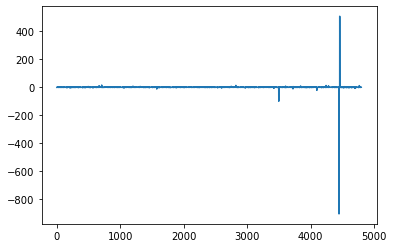

In [39]:
plt.plot(voice_dataset[1][0])

In [40]:
voice_dataset.get_audio(1500)

../openmic-2018/audio/091/091453_207360.ogg


In [41]:
def get_class_weights(dataset):
    """
    To handle imbalanced classes.
    """
    num_true = np.sum(np.array([i[1] for i in dataset]))
    # print(f"{(num_true/len(dataset))}")
    num_false = len(dataset) - num_true
    wt_true = len(dataset) / num_true
    wt_false = len(dataset) / num_false
    return torch.Tensor([wt_true if y > 0.5 else wt_false for x, y in dataset]), len(dataset)

In [42]:
def get_dataloader_dict(instrument='voice'):
    dataset = IRdataset(instrument)
    train_len = int(.6*len(dataset))
    val_len = int(.2*len(dataset))
    test_len = len(dataset) - train_len - val_len
    train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_len, val_len, test_len])
    batch_size = 2560
    
    sampler_train = torch.utils.data.sampler.WeightedRandomSampler(*get_class_weights(train_set))
    sampler_val = torch.utils.data.sampler.WeightedRandomSampler(*get_class_weights(val_set))
    sampler_test = torch.utils.data.sampler.WeightedRandomSampler(*get_class_weights(test_set))

    train_dl = DataLoader(train_set, batch_size=batch_size, sampler=sampler_train)
    val_dl = DataLoader(val_set, batch_size=batch_size, sampler=sampler_val)
    test_dl = DataLoader(test_set, batch_size=batch_size, sampler=sampler_test)
    dataloader_dict = {'train':train_dl, 'val': val_dl, 'test': test_dl}
    return dataloader_dict

In [43]:
get_dataloader_dict('voice')

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f2c5efb0a60>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f2c5efb0a30>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f2c5efb0a00>}

# Define Model

In [44]:
class BaseModel(nn.Module):
    def __init__(self, hidden_sizes=[512], p=.5):
        super(BaseModel, self).__init__()
        input_size = 4800
        self.hidden_sizes = [input_size] + hidden_sizes + [1]
        for i in range(1, len(self.hidden_sizes)):
            setattr(self, f"hidden_{i}", nn.Linear(self.hidden_sizes[i-1], self.hidden_sizes[i]))
        # self.lins = [nn.Linear(hidden_sizes[i-1], hidden_sizes[i]) for i in range(1, len(hidden_sizes))]
        self.dropout = nn.Dropout(p=p)
        
    def forward(self, x):
        # it seems like we're using a ton of dropout, but we basically use the same probe structure that
        # Jukemir uses (with dropout in the same spots)
        x = self.dropout(x)
        for i in range(1, len(self.hidden_sizes)-1):
            x = getattr(self, f"hidden_{i}")(x)
            x = F.relu(x)
            x = self.dropout(x)
        x = getattr(self, f"hidden_{len(self.hidden_sizes)-1}")(x) # output
        return x

In [45]:
model = BaseModel()
list(model.parameters())
print(model)

BaseModel(
  (hidden_1): Linear(in_features=4800, out_features=512, bias=True)
  (hidden_2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [46]:
model(torch.Tensor(np.ones(4800)))

tensor([-0.3109], grad_fn=<AddBackward0>)

# Training code

In [47]:
# taken from hw8, with modifications to make it print less
def train_model_classifier(model, dataloaders, criterion, optimizer, num_epochs=25, display=False):
    since = time.time()
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    

    iterator = range(num_epochs) if display else tqdm(range(num_epochs))
    for epoch in iterator:
        if display:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).flatten()
                    loss = criterion(outputs, labels)
                    preds = torch.sigmoid(outputs)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(torch.round(preds).int() == torch.round(labels.data).int())
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            if display:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
                if best_acc < epoch_acc:
                    best_acc = max(epoch_acc, best_acc)
                    best_model_wts = copy.deepcopy(model.state_dict())
            else:
                train_loss_history.append(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, val_acc_history, train_loss_history, val_loss_history

In [61]:
def he_initialization(m):
    """
    https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
    """
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight)


def train_and_display(model, dataloader_dict, num_epochs=100, regularization=1e-4, plot=True):
    """
    run the training using gradient descent and CE loss.
    plot validation and test loss, and valiation accuracy
    """
    alpha = 1e-4
    # beta  = 0
    # regularization = 1e-4
    
    model = model.to(device)
    model.apply(he_initialization)
    #optimizer = optim.SGD(model.parameters(), lr=alpha, momentum=beta)
    optimizer = optim.Adam(model.parameters(), lr=alpha, weight_decay=regularization)
    criterion = torch.nn.BCEWithLogitsLoss()
    model, val_acc_history, train_loss_history, val_loss_history = train_model_classifier(model, 
                                                                                          dataloader_dict,
                                                                                          criterion,
                                                                                          optimizer,
                                                                                          num_epochs)
    val_acc_history = [x.cpu() for x in val_acc_history]
    
    if plot:
        fig, ax = plt.subplots()
        ax.set_title("Train and Validation Loss, Validation accuracy vs. epoch")
        ax.set_xlabel("epoch")
        ax.set_ylabel("Cross Entropy Loss")
        loss1, = ax.plot(train_loss_history, label="train loss")
        loss2, = ax.plot(val_loss_history, label="validation loss")
        #ax.legend(loc='center right')

        ax2 = ax.twinx()
        acc, = ax2.plot(val_acc_history, color='r', label='validation accuracy')
        ax2.set_ylabel('accuracy')
        ax2.legend((loss1, loss2, acc), ('Train Loss', 'Validation Loss', 'Validation Accuracy'), loc='center right')
        ax2.set_ylim([0, 1.0])
    else:
        fig = None
    return model, fig, np.min(val_loss_history), val_acc_history[np.argmin(val_loss_history)]

# Eval

BaseModel(
  (hidden_1): Linear(in_features=4800, out_features=512, bias=True)
  (hidden_2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


100%|██████████| 100/100 [00:01<00:00, 61.41it/s]


Training complete in 0m 2s
Best val Acc: 0.948718


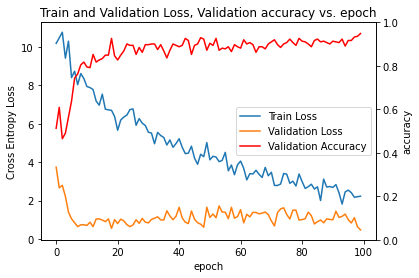

In [62]:
model = BaseModel([512])
print(model)
model, fig, _, _ = train_and_display(model, get_dataloader_dict('voice'), num_epochs=int(8e2))

100%|██████████| 800/800 [00:13<00:00, 59.48it/s]


Training complete in 0m 13s
Best val Acc: 0.974359


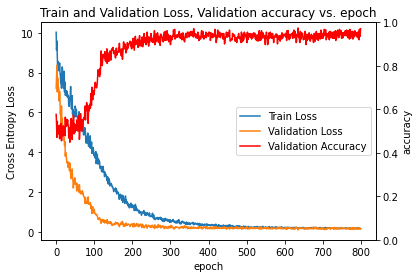

In [65]:
model, fig, _, _ = train_and_display(BaseModel([]), get_dataloader_dict('voice'), num_epochs=int(8e2))

100%|██████████| 800/800 [00:14<00:00, 54.11it/s]


Training complete in 0m 15s
Best val Acc: 0.967949


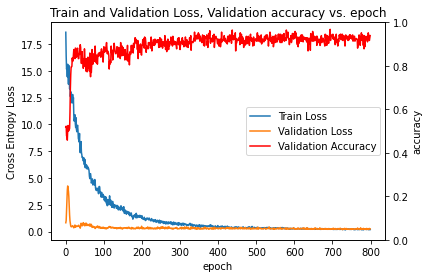

In [64]:
model, fig, _, _ = train_and_display(BaseModel([512, 256]), get_dataloader_dict('voice'), num_epochs=int(8e2))

## Evaluate multiple models

In [24]:
gs_hidden_sizes = [[], [512], [512, 256]]
gs_regularization = [0, 1e-4, 1e-3]
gs_dropout = [.25, .5, .75]

def gs_all_instruments(hidden_sizes=gs_hidden_sizes, 
                       regularization=gs_regularization, 
                       dropout=gs_dropout):
    models = {}
    losses = {}
    val_accs = {}
    params = {}
    
    for instrument in classes:
        best_model = None
        best_loss = np.inf
        best_params = []
        dl_dict = get_dataloader_dict(instrument)
        with open("test_sets/concat/" + instrument + ".pkl", "wb") as handle:
            pickle.dump(dl_dict, handle)
        for hs in hidden_sizes:
            for reg in regularization:
                for dp in dropout:
                    model, _, val_loss, val_acc = train_and_display(BaseModel(hidden_sizes=hs, p=dp), 
                                                           dl_dict,
                                                           num_epochs=int(8e2),
                                                           regularization = reg,
                                                           plot=False
                                                           )
                    if val_loss < best_loss:
                        best_model = model
                        best_loss = val_loss
                        best_acc = val_acc
                        best_params = [hs, reg, dp]
                        
        models[instrument] = best_model
        losses[instrument] = best_loss
        val_accs[instrument] = best_acc
        params[instrument] = best_params
        
    return models, losses, val_accs, params

In [ ]:
# models, losses, val_accs, params = gs_all_instruments()
# with open("gs_output_concatenated.pkl", 'wb') as handle:
#     pickle.dump((models, losses, val_accs, params), handle)

100%|██████████| 800/800 [00:16<00:00, 49.54it/s]


Training complete in 0m 16s
Best val Acc: 0.850242


100%|██████████| 800/800 [00:16<00:00, 49.09it/s]


Training complete in 0m 16s
Best val Acc: 0.828502


100%|██████████| 800/800 [00:16<00:00, 49.76it/s]


Training complete in 0m 16s
Best val Acc: 0.838164


100%|██████████| 800/800 [00:16<00:00, 49.45it/s]


Training complete in 0m 16s
Best val Acc: 0.859903


100%|██████████| 800/800 [00:16<00:00, 49.25it/s]


Training complete in 0m 16s
Best val Acc: 0.840580


100%|██████████| 800/800 [00:16<00:00, 49.52it/s]


Training complete in 0m 16s
Best val Acc: 0.845411


100%|██████████| 800/800 [00:16<00:00, 49.46it/s]


Training complete in 0m 16s
Best val Acc: 0.823671


100%|██████████| 800/800 [00:16<00:00, 49.18it/s]


Training complete in 0m 16s
Best val Acc: 0.852657


100%|██████████| 800/800 [00:16<00:00, 49.36it/s]


Training complete in 0m 16s
Best val Acc: 0.852657


100%|██████████| 800/800 [00:16<00:00, 47.36it/s]


Training complete in 0m 17s
Best val Acc: 0.850242


100%|██████████| 800/800 [00:16<00:00, 47.28it/s]


Training complete in 0m 17s
Best val Acc: 0.859903


100%|██████████| 800/800 [00:16<00:00, 47.17it/s]


Training complete in 0m 17s
Best val Acc: 0.814010


100%|██████████| 800/800 [00:16<00:00, 47.07it/s]


Training complete in 0m 17s
Best val Acc: 0.845411


100%|██████████| 800/800 [00:16<00:00, 47.11it/s]


Training complete in 0m 17s
Best val Acc: 0.850242


100%|██████████| 800/800 [00:17<00:00, 47.06it/s]


Training complete in 0m 17s
Best val Acc: 0.850242


100%|██████████| 800/800 [00:17<00:00, 46.95it/s]


Training complete in 0m 17s
Best val Acc: 0.857488


100%|██████████| 800/800 [00:16<00:00, 47.07it/s]


Training complete in 0m 17s
Best val Acc: 0.847826


100%|██████████| 800/800 [00:17<00:00, 47.02it/s]


Training complete in 0m 17s
Best val Acc: 0.852657


100%|██████████| 800/800 [00:17<00:00, 45.00it/s]


Training complete in 0m 18s
Best val Acc: 0.869565


100%|██████████| 800/800 [00:17<00:00, 45.11it/s]


Training complete in 0m 18s
Best val Acc: 0.760870


100%|██████████| 800/800 [00:17<00:00, 45.08it/s]


Training complete in 0m 18s
Best val Acc: 0.753623


100%|██████████| 800/800 [00:17<00:00, 44.90it/s]


Training complete in 0m 18s
Best val Acc: 0.859903


100%|██████████| 800/800 [00:17<00:00, 44.73it/s]


Training complete in 0m 18s
Best val Acc: 0.857488


100%|██████████| 800/800 [00:17<00:00, 44.95it/s]


Training complete in 0m 18s
Best val Acc: 0.799517


100%|██████████| 800/800 [00:17<00:00, 45.43it/s]


Training complete in 0m 18s
Best val Acc: 0.862319


100%|██████████| 800/800 [00:17<00:00, 45.87it/s]


Training complete in 0m 17s
Best val Acc: 0.821256


100%|██████████| 800/800 [00:17<00:00, 45.62it/s]


Training complete in 0m 18s
Best val Acc: 0.782609


100%|██████████| 800/800 [00:16<00:00, 48.19it/s]


Training complete in 0m 17s
Best val Acc: 0.835214


100%|██████████| 800/800 [00:16<00:00, 48.17it/s]


Training complete in 0m 17s
Best val Acc: 0.848758


100%|██████████| 800/800 [00:16<00:00, 48.25it/s]


Training complete in 0m 17s
Best val Acc: 0.846501


100%|██████████| 800/800 [00:16<00:00, 48.01it/s]


Training complete in 0m 17s
Best val Acc: 0.855530


100%|██████████| 800/800 [00:16<00:00, 48.30it/s]


Training complete in 0m 17s
Best val Acc: 0.851016


100%|██████████| 800/800 [00:16<00:00, 48.87it/s]


Training complete in 0m 16s
Best val Acc: 0.853273


100%|██████████| 800/800 [00:16<00:00, 48.52it/s]


Training complete in 0m 16s
Best val Acc: 0.855530


100%|██████████| 800/800 [00:16<00:00, 48.60it/s]


Training complete in 0m 16s
Best val Acc: 0.875847


100%|██████████| 800/800 [00:16<00:00, 48.72it/s]


Training complete in 0m 16s
Best val Acc: 0.862302


100%|██████████| 800/800 [00:16<00:00, 47.78it/s]


Training complete in 0m 17s
Best val Acc: 0.860045


100%|██████████| 800/800 [00:16<00:00, 47.84it/s]


Training complete in 0m 17s
Best val Acc: 0.855530


100%|██████████| 800/800 [00:16<00:00, 47.81it/s]


Training complete in 0m 17s
Best val Acc: 0.869074


100%|██████████| 800/800 [00:16<00:00, 47.12it/s]


Training complete in 0m 17s
Best val Acc: 0.846501


100%|██████████| 800/800 [00:17<00:00, 46.97it/s]


Training complete in 0m 17s
Best val Acc: 0.869074


100%|██████████| 800/800 [00:17<00:00, 46.79it/s]


Training complete in 0m 17s
Best val Acc: 0.871332


100%|██████████| 800/800 [00:16<00:00, 47.08it/s]


Training complete in 0m 17s
Best val Acc: 0.864560


100%|██████████| 800/800 [00:17<00:00, 46.66it/s]


Training complete in 0m 17s
Best val Acc: 0.851016


100%|██████████| 800/800 [00:17<00:00, 46.59it/s]


Training complete in 0m 17s
Best val Acc: 0.857788


100%|██████████| 800/800 [00:17<00:00, 45.21it/s]


Training complete in 0m 18s
Best val Acc: 0.864560


100%|██████████| 800/800 [00:17<00:00, 44.92it/s]


Training complete in 0m 18s
Best val Acc: 0.866817


100%|██████████| 800/800 [00:17<00:00, 44.93it/s]


Training complete in 0m 18s
Best val Acc: 0.871332


100%|██████████| 800/800 [00:17<00:00, 44.72it/s]


Training complete in 0m 18s
Best val Acc: 0.857788


100%|██████████| 800/800 [00:17<00:00, 44.72it/s]


Training complete in 0m 18s
Best val Acc: 0.848758


100%|██████████| 800/800 [00:17<00:00, 44.56it/s]


Training complete in 0m 18s
Best val Acc: 0.851016


100%|██████████| 800/800 [00:17<00:00, 44.70it/s]


Training complete in 0m 18s
Best val Acc: 0.864560


100%|██████████| 800/800 [00:17<00:00, 44.85it/s]


Training complete in 0m 18s
Best val Acc: 0.860045


100%|██████████| 800/800 [00:17<00:00, 44.82it/s]


Training complete in 0m 18s
Best val Acc: 0.848758


100%|██████████| 800/800 [00:14<00:00, 54.69it/s]


Training complete in 0m 15s
Best val Acc: 0.854111


100%|██████████| 800/800 [00:14<00:00, 54.13it/s]


Training complete in 0m 15s
Best val Acc: 0.883289


100%|██████████| 800/800 [00:14<00:00, 53.88it/s]


Training complete in 0m 15s
Best val Acc: 0.885942


100%|██████████| 800/800 [00:14<00:00, 54.01it/s]


Training complete in 0m 15s
Best val Acc: 0.864721


100%|██████████| 800/800 [00:14<00:00, 54.01it/s]


Training complete in 0m 15s
Best val Acc: 0.875332


100%|██████████| 800/800 [00:14<00:00, 54.04it/s]


Training complete in 0m 15s
Best val Acc: 0.880637


100%|██████████| 800/800 [00:14<00:00, 53.68it/s]


Training complete in 0m 15s
Best val Acc: 0.867374


100%|██████████| 800/800 [00:14<00:00, 53.93it/s]


Training complete in 0m 15s
Best val Acc: 0.872679


100%|██████████| 800/800 [00:14<00:00, 54.02it/s]


Training complete in 0m 15s
Best val Acc: 0.875332


100%|██████████| 800/800 [00:15<00:00, 51.57it/s]


Training complete in 0m 16s
Best val Acc: 0.862069


100%|██████████| 800/800 [00:15<00:00, 51.38it/s]


Training complete in 0m 16s
Best val Acc: 0.867374


100%|██████████| 800/800 [00:15<00:00, 51.87it/s]


Training complete in 0m 15s
Best val Acc: 0.877984


100%|██████████| 800/800 [00:15<00:00, 51.88it/s]


Training complete in 0m 15s
Best val Acc: 0.891247


100%|██████████| 800/800 [00:15<00:00, 51.40it/s]


Training complete in 0m 16s
Best val Acc: 0.872679


100%|██████████| 800/800 [00:15<00:00, 51.68it/s]


Training complete in 0m 15s
Best val Acc: 0.885942


100%|██████████| 800/800 [00:15<00:00, 51.68it/s]


Training complete in 0m 15s
Best val Acc: 0.885942


100%|██████████| 800/800 [00:15<00:00, 51.55it/s]


Training complete in 0m 16s
Best val Acc: 0.885942


100%|██████████| 800/800 [00:15<00:00, 51.48it/s]


Training complete in 0m 16s
Best val Acc: 0.875332


100%|██████████| 800/800 [00:16<00:00, 49.55it/s]


Training complete in 0m 16s
Best val Acc: 0.883289


100%|██████████| 800/800 [00:16<00:00, 49.55it/s]


Training complete in 0m 16s
Best val Acc: 0.843501


100%|██████████| 800/800 [00:16<00:00, 49.38it/s]


Training complete in 0m 16s
Best val Acc: 0.819629


100%|██████████| 800/800 [00:16<00:00, 49.48it/s]


Training complete in 0m 16s
Best val Acc: 0.872679


100%|██████████| 800/800 [00:16<00:00, 49.31it/s]


Training complete in 0m 16s
Best val Acc: 0.885942


100%|██████████| 800/800 [00:16<00:00, 49.23it/s]


Training complete in 0m 16s
Best val Acc: 0.835544


100%|██████████| 800/800 [00:16<00:00, 49.32it/s]


Training complete in 0m 16s
Best val Acc: 0.877984


100%|██████████| 800/800 [00:16<00:00, 49.30it/s]


Training complete in 0m 16s
Best val Acc: 0.862069


100%|██████████| 800/800 [00:16<00:00, 49.05it/s]


Training complete in 0m 16s
Best val Acc: 0.864721


100%|██████████| 800/800 [00:14<00:00, 54.40it/s]


Training complete in 0m 15s
Best val Acc: 0.866324


100%|██████████| 800/800 [00:14<00:00, 53.68it/s]


Training complete in 0m 15s
Best val Acc: 0.886889


100%|██████████| 800/800 [00:15<00:00, 53.32it/s]


Training complete in 0m 15s
Best val Acc: 0.892031


100%|██████████| 800/800 [00:14<00:00, 53.50it/s]


Training complete in 0m 15s
Best val Acc: 0.881748


100%|██████████| 800/800 [00:14<00:00, 53.47it/s]


Training complete in 0m 15s
Best val Acc: 0.881748


100%|██████████| 800/800 [00:14<00:00, 53.50it/s]


Training complete in 0m 15s
Best val Acc: 0.889460


100%|██████████| 800/800 [00:15<00:00, 53.33it/s]


Training complete in 0m 15s
Best val Acc: 0.907455


100%|██████████| 800/800 [00:14<00:00, 53.52it/s]


Training complete in 0m 15s
Best val Acc: 0.881748


100%|██████████| 800/800 [00:14<00:00, 53.79it/s]


Training complete in 0m 15s
Best val Acc: 0.902314


100%|██████████| 800/800 [00:15<00:00, 51.31it/s]


Training complete in 0m 16s
Best val Acc: 0.907455


100%|██████████| 800/800 [00:15<00:00, 51.49it/s]


Training complete in 0m 16s
Best val Acc: 0.886889


100%|██████████| 800/800 [00:15<00:00, 51.44it/s]


Training complete in 0m 16s
Best val Acc: 0.899743


100%|██████████| 800/800 [00:15<00:00, 51.16it/s]


Training complete in 0m 16s
Best val Acc: 0.886889


100%|██████████| 800/800 [00:15<00:00, 51.08it/s]


Training complete in 0m 16s
Best val Acc: 0.874036


100%|██████████| 800/800 [00:15<00:00, 51.16it/s]


Training complete in 0m 16s
Best val Acc: 0.889460


100%|██████████| 800/800 [00:15<00:00, 51.21it/s]


Training complete in 0m 16s
Best val Acc: 0.899743


100%|██████████| 800/800 [00:15<00:00, 52.86it/s]


Training complete in 0m 15s
Best val Acc: 0.897172


100%|██████████| 800/800 [00:15<00:00, 52.45it/s]


Training complete in 0m 15s
Best val Acc: 0.879177


100%|██████████| 800/800 [00:15<00:00, 50.70it/s]


Training complete in 0m 16s
Best val Acc: 0.892031


100%|██████████| 800/800 [00:15<00:00, 50.68it/s]


Training complete in 0m 16s
Best val Acc: 0.879177


100%|██████████| 800/800 [00:15<00:00, 50.56it/s]


Training complete in 0m 16s
Best val Acc: 0.876607


100%|██████████| 800/800 [00:15<00:00, 50.60it/s]


Training complete in 0m 16s
Best val Acc: 0.902314


100%|██████████| 800/800 [00:15<00:00, 50.47it/s]


Training complete in 0m 16s
Best val Acc: 0.876607


100%|██████████| 800/800 [00:15<00:00, 50.58it/s]


Training complete in 0m 16s
Best val Acc: 0.884319


100%|██████████| 800/800 [00:15<00:00, 50.63it/s]


Training complete in 0m 16s
Best val Acc: 0.902314


100%|██████████| 800/800 [00:15<00:00, 50.53it/s]


Training complete in 0m 16s
Best val Acc: 0.881748


100%|██████████| 800/800 [00:15<00:00, 50.38it/s]


Training complete in 0m 16s
Best val Acc: 0.835476


100%|██████████| 800/800 [00:17<00:00, 44.90it/s]


Training complete in 0m 18s
Best val Acc: 0.756813


100%|██████████| 800/800 [00:17<00:00, 44.87it/s]


Training complete in 0m 18s
Best val Acc: 0.767296


100%|██████████| 800/800 [00:17<00:00, 44.84it/s]


Training complete in 0m 18s
Best val Acc: 0.781971


100%|██████████| 800/800 [00:17<00:00, 44.95it/s]


Training complete in 0m 18s
Best val Acc: 0.779874


100%|██████████| 800/800 [00:17<00:00, 44.90it/s]


Training complete in 0m 18s
Best val Acc: 0.790356


100%|██████████| 800/800 [00:17<00:00, 44.77it/s]


Training complete in 0m 18s
Best val Acc: 0.767296


100%|██████████| 800/800 [00:17<00:00, 44.91it/s]


Training complete in 0m 18s
Best val Acc: 0.763103


100%|██████████| 800/800 [00:17<00:00, 44.89it/s]


Training complete in 0m 18s
Best val Acc: 0.775681


100%|██████████| 800/800 [00:18<00:00, 44.39it/s]


Training complete in 0m 18s
Best val Acc: 0.781971


100%|██████████| 800/800 [00:18<00:00, 43.40it/s]


Training complete in 0m 18s
Best val Acc: 0.761006


100%|██████████| 800/800 [00:18<00:00, 43.04it/s]


Training complete in 0m 19s
Best val Acc: 0.790356


100%|██████████| 800/800 [00:18<00:00, 42.16it/s]


Training complete in 0m 19s
Best val Acc: 0.769392


100%|██████████| 800/800 [00:18<00:00, 42.34it/s]


Training complete in 0m 19s
Best val Acc: 0.771488


100%|██████████| 800/800 [00:18<00:00, 42.41it/s]


Training complete in 0m 19s
Best val Acc: 0.765199


100%|██████████| 800/800 [00:18<00:00, 42.47it/s]


Training complete in 0m 19s
Best val Acc: 0.769392


100%|██████████| 800/800 [00:18<00:00, 42.31it/s]


Training complete in 0m 19s
Best val Acc: 0.769392


100%|██████████| 800/800 [00:18<00:00, 42.63it/s]


Training complete in 0m 19s
Best val Acc: 0.777778


100%|██████████| 800/800 [00:18<00:00, 42.68it/s]


Training complete in 0m 19s
Best val Acc: 0.761006


100%|██████████| 800/800 [00:19<00:00, 40.52it/s]


Training complete in 0m 20s
Best val Acc: 0.781971


100%|██████████| 800/800 [00:19<00:00, 40.58it/s]


Training complete in 0m 20s
Best val Acc: 0.758910


100%|██████████| 800/800 [00:19<00:00, 40.67it/s]


Training complete in 0m 20s
Best val Acc: 0.723270


100%|██████████| 800/800 [00:19<00:00, 40.51it/s]


Training complete in 0m 20s
Best val Acc: 0.754717


100%|██████████| 800/800 [00:19<00:00, 40.67it/s]


Training complete in 0m 20s
Best val Acc: 0.775681


100%|██████████| 800/800 [00:19<00:00, 40.62it/s]


Training complete in 0m 20s
Best val Acc: 0.748428


100%|██████████| 800/800 [00:19<00:00, 40.51it/s]


Training complete in 0m 20s
Best val Acc: 0.786164


100%|██████████| 800/800 [00:19<00:00, 40.67it/s]


Training complete in 0m 20s
Best val Acc: 0.744235


100%|██████████| 800/800 [00:19<00:00, 40.54it/s]


Training complete in 0m 20s
Best val Acc: 0.733753


100%|██████████| 800/800 [00:13<00:00, 60.15it/s]


Training complete in 0m 13s
Best val Acc: 0.945245


100%|██████████| 800/800 [00:13<00:00, 60.42it/s]


Training complete in 0m 13s
Best val Acc: 0.951009


100%|██████████| 800/800 [00:13<00:00, 60.01it/s]


Training complete in 0m 13s
Best val Acc: 0.951009


100%|██████████| 800/800 [00:13<00:00, 59.96it/s]


Training complete in 0m 13s
Best val Acc: 0.953890


100%|██████████| 800/800 [00:13<00:00, 60.36it/s]


Training complete in 0m 13s
Best val Acc: 0.953890


100%|██████████| 800/800 [00:13<00:00, 59.30it/s]


Training complete in 0m 13s
Best val Acc: 0.959654


100%|██████████| 800/800 [00:13<00:00, 58.94it/s]


Training complete in 0m 14s
Best val Acc: 0.962536


100%|██████████| 800/800 [00:13<00:00, 58.70it/s]


Training complete in 0m 14s
Best val Acc: 0.953890


100%|██████████| 800/800 [00:13<00:00, 58.95it/s]


Training complete in 0m 14s
Best val Acc: 0.951009


100%|██████████| 800/800 [00:14<00:00, 55.69it/s]


Training complete in 0m 14s
Best val Acc: 0.962536


100%|██████████| 800/800 [00:14<00:00, 55.47it/s]


Training complete in 0m 14s
Best val Acc: 0.953890


100%|██████████| 800/800 [00:14<00:00, 55.74it/s]


Training complete in 0m 14s
Best val Acc: 0.953890


100%|██████████| 800/800 [00:14<00:00, 55.37it/s]


Training complete in 0m 14s
Best val Acc: 0.956772


100%|██████████| 800/800 [00:14<00:00, 55.31it/s]


Training complete in 0m 14s
Best val Acc: 0.962536


100%|██████████| 800/800 [00:14<00:00, 55.48it/s]


Training complete in 0m 14s
Best val Acc: 0.953890


100%|██████████| 800/800 [00:15<00:00, 53.16it/s]


Training complete in 0m 15s
Best val Acc: 0.965418


100%|██████████| 800/800 [00:14<00:00, 55.09it/s]


Training complete in 0m 15s
Best val Acc: 0.962536


100%|██████████| 800/800 [00:14<00:00, 56.49it/s]


Training complete in 0m 14s
Best val Acc: 0.956772


100%|██████████| 800/800 [00:14<00:00, 53.85it/s]


Training complete in 0m 15s
Best val Acc: 0.968300


100%|██████████| 800/800 [00:14<00:00, 53.73it/s]


Training complete in 0m 15s
Best val Acc: 0.953890


100%|██████████| 800/800 [00:14<00:00, 53.72it/s]


Training complete in 0m 15s
Best val Acc: 0.933718


100%|██████████| 800/800 [00:14<00:00, 53.51it/s]


Training complete in 0m 15s
Best val Acc: 0.948127


100%|██████████| 800/800 [00:14<00:00, 53.58it/s]


Training complete in 0m 15s
Best val Acc: 0.962536


100%|██████████| 800/800 [00:15<00:00, 52.88it/s]


Training complete in 0m 15s
Best val Acc: 0.939481


100%|██████████| 800/800 [00:15<00:00, 52.19it/s]


Training complete in 0m 15s
Best val Acc: 0.959654


100%|██████████| 800/800 [00:15<00:00, 52.57it/s]


Training complete in 0m 15s
Best val Acc: 0.974063


100%|██████████| 800/800 [00:15<00:00, 52.76it/s]


Training complete in 0m 15s
Best val Acc: 0.933718


100%|██████████| 800/800 [00:14<00:00, 56.38it/s]


Training complete in 0m 14s
Best val Acc: 0.968481


100%|██████████| 800/800 [00:14<00:00, 56.50it/s]


Training complete in 0m 14s
Best val Acc: 0.979943


100%|██████████| 800/800 [00:14<00:00, 56.40it/s]


Training complete in 0m 14s
Best val Acc: 0.974212


100%|██████████| 800/800 [00:14<00:00, 56.23it/s]


Training complete in 0m 14s
Best val Acc: 0.962751


100%|██████████| 800/800 [00:14<00:00, 56.33it/s]


Training complete in 0m 14s
Best val Acc: 0.979943


100%|██████████| 800/800 [00:14<00:00, 56.36it/s]


Training complete in 0m 14s
Best val Acc: 0.971347


100%|██████████| 800/800 [00:13<00:00, 57.89it/s]


Training complete in 0m 14s
Best val Acc: 0.965616


100%|██████████| 800/800 [00:13<00:00, 57.74it/s]


Training complete in 0m 14s
Best val Acc: 0.962751


100%|██████████| 800/800 [00:13<00:00, 57.80it/s]


Training complete in 0m 14s
Best val Acc: 0.971347


100%|██████████| 800/800 [00:14<00:00, 54.87it/s]


Training complete in 0m 15s
Best val Acc: 0.985673


100%|██████████| 800/800 [00:14<00:00, 54.64it/s]


Training complete in 0m 15s
Best val Acc: 0.982808


100%|██████████| 800/800 [00:14<00:00, 53.89it/s]


Training complete in 0m 15s
Best val Acc: 0.974212


100%|██████████| 800/800 [00:14<00:00, 53.96it/s]


Training complete in 0m 15s
Best val Acc: 0.982808


100%|██████████| 800/800 [00:14<00:00, 54.42it/s]


Training complete in 0m 15s
Best val Acc: 0.991404


100%|██████████| 800/800 [00:14<00:00, 55.21it/s]


Training complete in 0m 14s
Best val Acc: 0.977077


100%|██████████| 800/800 [00:14<00:00, 55.27it/s]


Training complete in 0m 14s
Best val Acc: 0.988539


100%|██████████| 800/800 [00:14<00:00, 55.28it/s]


Training complete in 0m 14s
Best val Acc: 0.985673


100%|██████████| 800/800 [00:14<00:00, 55.34it/s]


Training complete in 0m 14s
Best val Acc: 0.977077


100%|██████████| 800/800 [00:15<00:00, 52.79it/s]


Training complete in 0m 15s
Best val Acc: 0.977077


100%|██████████| 800/800 [00:15<00:00, 52.85it/s]


Training complete in 0m 15s
Best val Acc: 0.979943


100%|██████████| 800/800 [00:15<00:00, 53.01it/s]


Training complete in 0m 15s
Best val Acc: 0.951289


100%|██████████| 800/800 [00:15<00:00, 52.52it/s]


Training complete in 0m 15s
Best val Acc: 0.979943


100%|██████████| 800/800 [00:15<00:00, 52.79it/s]


Training complete in 0m 15s
Best val Acc: 0.968481


100%|██████████| 800/800 [00:15<00:00, 52.82it/s]


Training complete in 0m 15s
Best val Acc: 0.971347


100%|██████████| 800/800 [00:15<00:00, 52.46it/s]


Training complete in 0m 15s
Best val Acc: 0.982808


100%|██████████| 800/800 [00:15<00:00, 52.59it/s]


Training complete in 0m 15s
Best val Acc: 0.965616


100%|██████████| 800/800 [00:15<00:00, 52.66it/s]


Training complete in 0m 15s
Best val Acc: 0.957020


100%|██████████| 800/800 [00:16<00:00, 49.31it/s]


Training complete in 0m 16s
Best val Acc: 0.771635


100%|██████████| 800/800 [00:16<00:00, 49.00it/s]


Training complete in 0m 16s
Best val Acc: 0.790865


100%|██████████| 800/800 [00:15<00:00, 50.13it/s]


Training complete in 0m 16s
Best val Acc: 0.774038


100%|██████████| 800/800 [00:16<00:00, 49.72it/s]


Training complete in 0m 16s
Best val Acc: 0.776442


100%|██████████| 800/800 [00:16<00:00, 49.85it/s]


Training complete in 0m 16s
Best val Acc: 0.795673


100%|██████████| 800/800 [00:16<00:00, 49.60it/s]


Training complete in 0m 16s
Best val Acc: 0.766827


100%|██████████| 800/800 [00:16<00:00, 49.74it/s]


Training complete in 0m 16s
Best val Acc: 0.778846


100%|██████████| 800/800 [00:16<00:00, 49.70it/s]


Training complete in 0m 16s
Best val Acc: 0.759615


100%|██████████| 800/800 [00:16<00:00, 49.57it/s]


Training complete in 0m 16s
Best val Acc: 0.788462


100%|██████████| 800/800 [00:16<00:00, 47.84it/s]


Training complete in 0m 17s
Best val Acc: 0.793269


100%|██████████| 800/800 [00:16<00:00, 47.45it/s]


Training complete in 0m 17s
Best val Acc: 0.802885


100%|██████████| 800/800 [00:16<00:00, 47.75it/s]


Training complete in 0m 17s
Best val Acc: 0.771635


100%|██████████| 800/800 [00:16<00:00, 47.66it/s]


Training complete in 0m 17s
Best val Acc: 0.790865


100%|██████████| 800/800 [00:16<00:00, 47.55it/s]


Training complete in 0m 17s
Best val Acc: 0.776442


100%|██████████| 800/800 [00:16<00:00, 47.65it/s]


Training complete in 0m 17s
Best val Acc: 0.781250


100%|██████████| 800/800 [00:16<00:00, 47.63it/s]


Training complete in 0m 17s
Best val Acc: 0.783654


100%|██████████| 800/800 [00:16<00:00, 47.62it/s]


Training complete in 0m 17s
Best val Acc: 0.800481


100%|██████████| 800/800 [00:16<00:00, 47.64it/s]


Training complete in 0m 17s
Best val Acc: 0.805288


100%|██████████| 800/800 [00:17<00:00, 45.62it/s]


Training complete in 0m 18s
Best val Acc: 0.776442


100%|██████████| 800/800 [00:17<00:00, 45.80it/s]


Training complete in 0m 17s
Best val Acc: 0.769231


100%|██████████| 800/800 [00:17<00:00, 45.78it/s]


Training complete in 0m 17s
Best val Acc: 0.742788


100%|██████████| 800/800 [00:17<00:00, 45.78it/s]


Training complete in 0m 17s
Best val Acc: 0.781250


100%|██████████| 800/800 [00:17<00:00, 45.70it/s]


Training complete in 0m 18s
Best val Acc: 0.798077


100%|██████████| 800/800 [00:17<00:00, 45.68it/s]


Training complete in 0m 18s
Best val Acc: 0.762019


100%|██████████| 800/800 [00:17<00:00, 45.33it/s]


Training complete in 0m 18s
Best val Acc: 0.781250


100%|██████████| 800/800 [00:17<00:00, 45.57it/s]


Training complete in 0m 18s
Best val Acc: 0.769231


100%|██████████| 800/800 [00:17<00:00, 45.60it/s]


Training complete in 0m 18s
Best val Acc: 0.819712


100%|██████████| 800/800 [00:12<00:00, 64.01it/s]


Training complete in 0m 13s
Best val Acc: 0.966667


100%|██████████| 800/800 [00:12<00:00, 64.74it/s]


Training complete in 0m 12s
Best val Acc: 0.978788


100%|██████████| 800/800 [00:12<00:00, 64.08it/s]


Training complete in 0m 12s
Best val Acc: 0.969697


100%|██████████| 800/800 [00:12<00:00, 64.04it/s]


Training complete in 0m 12s
Best val Acc: 0.963636


100%|██████████| 800/800 [00:12<00:00, 64.07it/s]


Training complete in 0m 12s
Best val Acc: 0.975758


100%|██████████| 800/800 [00:12<00:00, 64.04it/s]


Training complete in 0m 12s
Best val Acc: 0.975758


100%|██████████| 800/800 [00:12<00:00, 63.95it/s]


Training complete in 0m 13s
Best val Acc: 0.975758


100%|██████████| 800/800 [00:12<00:00, 64.05it/s]


Training complete in 0m 12s
Best val Acc: 0.975758


100%|██████████| 800/800 [00:12<00:00, 63.92it/s]


Training complete in 0m 13s
Best val Acc: 0.969697


100%|██████████| 800/800 [00:13<00:00, 60.95it/s]


Training complete in 0m 13s
Best val Acc: 0.978788


100%|██████████| 800/800 [00:13<00:00, 61.32it/s]


Training complete in 0m 13s
Best val Acc: 0.975758


100%|██████████| 800/800 [00:13<00:00, 60.87it/s]


Training complete in 0m 13s
Best val Acc: 0.981818


100%|██████████| 800/800 [00:13<00:00, 61.05it/s]


Training complete in 0m 13s
Best val Acc: 0.972727


100%|██████████| 800/800 [00:13<00:00, 60.99it/s]


Training complete in 0m 13s
Best val Acc: 0.975758


100%|██████████| 800/800 [00:13<00:00, 60.69it/s]


Training complete in 0m 13s
Best val Acc: 0.969697


100%|██████████| 800/800 [00:13<00:00, 60.74it/s]


Training complete in 0m 13s
Best val Acc: 0.978788


100%|██████████| 800/800 [00:13<00:00, 60.50it/s]


Training complete in 0m 13s
Best val Acc: 0.981818


100%|██████████| 800/800 [00:13<00:00, 60.93it/s]


Training complete in 0m 13s
Best val Acc: 0.969697


100%|██████████| 800/800 [00:13<00:00, 57.55it/s]


Training complete in 0m 14s
Best val Acc: 0.981818


100%|██████████| 800/800 [00:13<00:00, 57.66it/s]


Training complete in 0m 14s
Best val Acc: 0.972727


100%|██████████| 800/800 [00:13<00:00, 57.71it/s]


Training complete in 0m 14s
Best val Acc: 0.966667


100%|██████████| 800/800 [00:13<00:00, 57.48it/s]


Training complete in 0m 14s
Best val Acc: 0.978788


100%|██████████| 800/800 [00:13<00:00, 57.43it/s]


Training complete in 0m 14s
Best val Acc: 0.975758


100%|██████████| 800/800 [00:13<00:00, 57.53it/s]


Training complete in 0m 14s
Best val Acc: 0.969697


100%|██████████| 800/800 [00:13<00:00, 57.49it/s]


Training complete in 0m 14s
Best val Acc: 0.981818


100%|██████████| 800/800 [00:13<00:00, 57.43it/s]


Training complete in 0m 14s
Best val Acc: 0.978788


100%|██████████| 800/800 [00:13<00:00, 57.43it/s]


Training complete in 0m 14s
Best val Acc: 0.963636


100%|██████████| 800/800 [00:14<00:00, 56.81it/s]


Training complete in 0m 14s
Best val Acc: 0.861111


100%|██████████| 800/800 [00:13<00:00, 57.29it/s]


Training complete in 0m 14s
Best val Acc: 0.875000


100%|██████████| 800/800 [00:14<00:00, 56.94it/s]


Training complete in 0m 14s
Best val Acc: 0.866667


100%|██████████| 800/800 [00:14<00:00, 57.08it/s]


Training complete in 0m 14s
Best val Acc: 0.847222


100%|██████████| 800/800 [00:14<00:00, 56.43it/s]


Training complete in 0m 14s
Best val Acc: 0.830556


100%|██████████| 800/800 [00:14<00:00, 56.28it/s]


Training complete in 0m 14s
Best val Acc: 0.850000


100%|██████████| 800/800 [00:14<00:00, 56.39it/s]


Training complete in 0m 14s
Best val Acc: 0.861111


100%|██████████| 800/800 [00:14<00:00, 56.43it/s]


Training complete in 0m 14s
Best val Acc: 0.852778


100%|██████████| 800/800 [00:14<00:00, 56.16it/s]


Training complete in 0m 14s
Best val Acc: 0.869444


100%|██████████| 800/800 [00:14<00:00, 54.68it/s]


Training complete in 0m 15s
Best val Acc: 0.875000


100%|██████████| 800/800 [00:14<00:00, 54.98it/s]


Training complete in 0m 15s
Best val Acc: 0.875000


100%|██████████| 800/800 [00:14<00:00, 54.60it/s]


Training complete in 0m 15s
Best val Acc: 0.869444


100%|██████████| 800/800 [00:14<00:00, 54.86it/s]


Training complete in 0m 15s
Best val Acc: 0.872222


100%|██████████| 800/800 [00:14<00:00, 54.75it/s]


Training complete in 0m 15s
Best val Acc: 0.869444


100%|██████████| 800/800 [00:14<00:00, 54.77it/s]


Training complete in 0m 15s
Best val Acc: 0.858333


100%|██████████| 800/800 [00:14<00:00, 54.63it/s]


Training complete in 0m 15s
Best val Acc: 0.866667


100%|██████████| 800/800 [00:14<00:00, 54.79it/s]


Training complete in 0m 15s
Best val Acc: 0.858333


100%|██████████| 800/800 [00:14<00:00, 54.58it/s]


Training complete in 0m 15s
Best val Acc: 0.869444


100%|██████████| 800/800 [00:15<00:00, 52.51it/s]


Training complete in 0m 15s
Best val Acc: 0.869444


100%|██████████| 800/800 [00:15<00:00, 52.07it/s]


Training complete in 0m 15s
Best val Acc: 0.844444


100%|██████████| 800/800 [00:15<00:00, 52.36it/s]


Training complete in 0m 15s
Best val Acc: 0.794444


100%|██████████| 800/800 [00:15<00:00, 52.18it/s]


Training complete in 0m 15s
Best val Acc: 0.875000


100%|██████████| 800/800 [00:15<00:00, 52.32it/s]


Training complete in 0m 15s
Best val Acc: 0.855556


100%|██████████| 800/800 [00:15<00:00, 51.97it/s]


Training complete in 0m 15s
Best val Acc: 0.813889


100%|██████████| 800/800 [00:15<00:00, 52.21it/s]


Training complete in 0m 15s
Best val Acc: 0.872222


100%|██████████| 800/800 [00:15<00:00, 52.14it/s]


Training complete in 0m 15s
Best val Acc: 0.858333


100%|██████████| 800/800 [00:15<00:00, 52.10it/s]


Training complete in 0m 15s
Best val Acc: 0.841667


100%|██████████| 800/800 [00:18<00:00, 43.23it/s]


Training complete in 0m 19s
Best val Acc: 0.796748


100%|██████████| 800/800 [00:18<00:00, 43.26it/s]


Training complete in 0m 18s
Best val Acc: 0.813008


100%|██████████| 800/800 [00:18<00:00, 43.10it/s]


Training complete in 0m 19s
Best val Acc: 0.808943


100%|██████████| 800/800 [00:18<00:00, 43.21it/s]


Training complete in 0m 19s
Best val Acc: 0.794715


100%|██████████| 800/800 [00:18<00:00, 43.09it/s]


Training complete in 0m 19s
Best val Acc: 0.796748


100%|██████████| 800/800 [00:18<00:00, 43.13it/s]


Training complete in 0m 19s
Best val Acc: 0.790650


100%|██████████| 800/800 [00:18<00:00, 42.95it/s]


Training complete in 0m 19s
Best val Acc: 0.808943


100%|██████████| 800/800 [00:18<00:00, 43.15it/s]


Training complete in 0m 19s
Best val Acc: 0.815041


100%|██████████| 800/800 [00:18<00:00, 43.17it/s]


Training complete in 0m 19s
Best val Acc: 0.788618


100%|██████████| 800/800 [00:19<00:00, 41.86it/s]


Training complete in 0m 19s
Best val Acc: 0.796748


100%|██████████| 800/800 [00:19<00:00, 41.10it/s]


Training complete in 0m 19s
Best val Acc: 0.792683


100%|██████████| 800/800 [00:19<00:00, 41.12it/s]


Training complete in 0m 19s
Best val Acc: 0.776423


100%|██████████| 800/800 [00:19<00:00, 40.84it/s]


Training complete in 0m 20s
Best val Acc: 0.837398


100%|██████████| 800/800 [00:19<00:00, 41.06it/s]


Training complete in 0m 19s
Best val Acc: 0.802846


100%|██████████| 800/800 [00:19<00:00, 41.09it/s]


Training complete in 0m 19s
Best val Acc: 0.800813


100%|██████████| 800/800 [00:19<00:00, 41.04it/s]


Training complete in 0m 19s
Best val Acc: 0.786585


100%|██████████| 800/800 [00:19<00:00, 41.54it/s]


Training complete in 0m 19s
Best val Acc: 0.815041


100%|██████████| 800/800 [00:19<00:00, 41.52it/s]


Training complete in 0m 19s
Best val Acc: 0.794715


100%|██████████| 800/800 [00:20<00:00, 39.96it/s]


Training complete in 0m 20s
Best val Acc: 0.798780


100%|██████████| 800/800 [00:19<00:00, 40.07it/s]


Training complete in 0m 20s
Best val Acc: 0.786585


100%|██████████| 800/800 [00:19<00:00, 40.01it/s]


Training complete in 0m 20s
Best val Acc: 0.796748


100%|██████████| 800/800 [00:19<00:00, 40.04it/s]


Training complete in 0m 20s
Best val Acc: 0.804878


100%|██████████| 800/800 [00:20<00:00, 39.85it/s]


Training complete in 0m 20s
Best val Acc: 0.778455


100%|██████████| 800/800 [00:20<00:00, 39.97it/s]


Training complete in 0m 20s
Best val Acc: 0.780488


100%|██████████| 800/800 [00:20<00:00, 40.00it/s]


Training complete in 0m 20s
Best val Acc: 0.800813


100%|██████████| 800/800 [00:20<00:00, 39.83it/s]


Training complete in 0m 20s
Best val Acc: 0.786585


100%|██████████| 800/800 [00:19<00:00, 40.04it/s]


Training complete in 0m 20s
Best val Acc: 0.782520


 13%|█▎        | 102/800 [00:01<00:13, 53.21it/s]

In [ ]:
with open("gs_output_concatenated.pkl", 'rb') as handle:
    models, losses, val_accs, params = pickle.load(handle)

In [28]:
val_accs

{'accordion': tensor(0.8502, dtype=torch.float64),
 'banjo': tensor(0.8555, dtype=torch.float64),
 'bass': tensor(0.8568, dtype=torch.float64),
 'cello': tensor(0.9023, dtype=torch.float64),
 'clarinet': tensor(0.7757, dtype=torch.float64),
 'cymbals': tensor(0.9539, dtype=torch.float64),
 'drums': tensor(0.9628, dtype=torch.float64),
 'flute': tensor(0.7716, dtype=torch.float64),
 'guitar': tensor(0.9636, dtype=torch.float64),
 'mallet_percussion': tensor(0.8667, dtype=torch.float64),
 'mandolin': tensor(0.8089, dtype=torch.float64),
 'organ': tensor(0.8651, dtype=torch.float64),
 'piano': tensor(0.9680, dtype=torch.float64),
 'saxophone': tensor(0.9070, dtype=torch.float64),
 'synthesizer': tensor(0.9563, dtype=torch.float64),
 'trombone': tensor(0.8478, dtype=torch.float64),
 'trumpet': tensor(0.9022, dtype=torch.float64),
 'ukulele': tensor(0.8165, dtype=torch.float64),
 'violin': tensor(0.8966, dtype=torch.float64),
 'voice': tensor(0.9744, dtype=torch.float64)}